variable_list: ['Activity', 'Licks', 'R_loc', 'Speed', '#1', '#2', '#3', '#4', '#5', '#6', '#7', '#8', '#9', '#10']
 shape neuron_data_filtered (50, 10, 390)
weights shape: (10,)


UnboundLocalError: cannot access local variable 'plot_example_neuron_variables' where it is not associated with a value

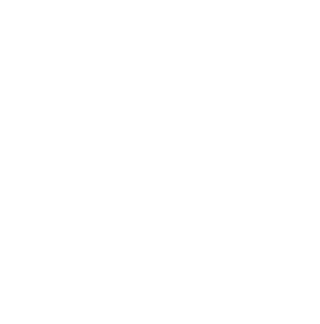

In [1]:
from GLM_regression import *
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams.update({'font.size': 10,
                     'axes.spines.right': False,
                     'axes.spines.top': False,
                     'legend.frameon': False})


# filepath = "SSTindivsomata_GLM.mat"
filepath = "NDNFindivsomata_GLM.mat"

reorganized_data, variable_list = load_data(filepath)
print(f"variable_list: {variable_list}")


def plot_example_neuron_vars_removed(reorganized_data, variable_list, neuron='best', animal='best', vars_to_remove=[], model_name=None):

    GLM_params = {}
    
    if animal == 'best' or neuron == 'best':
        best_R2 = -np.inf
        best_animal = None
        best_neuron = None
        for animal_key in reorganized_data:
            GLM_params[animal_key] = {}
            for i, neuron_data in enumerate(reorganized_data[animal_key]):
                # Prepare data and train GLM
                neuron_data = reorganized_data[animal_key][i][:, :, 1:]
                neuron_data = neuron_data[:, :, ~np.isnan(neuron_data).any(axis=(0, 1))]

                def remove_variables(neuron_data, variable_list, vars_to_remove):
                    # Exclude the first column, which is the neuron activity
                    all_data_excluding_activity_var = neuron_data[:, 1:, :]  # Shape: (num_time_points, num_variables - 1, num_trials)

                    # Ensure vars_to_remove is a list, even if it's an integer
                    if isinstance(vars_to_remove, int):
                        vars_to_remove = [vars_to_remove]

                    if vars_to_remove is not None:
                        # Get the indices of the variables to remove based on their names
                        var_indices_to_remove = [variable_list.index(var) for var in vars_to_remove]
                        # Create an array of indices to keep, excluding the ones we want to remove
                        vars_to_exclude = np.delete(np.arange(all_data_excluding_activity_var.shape[1]), var_indices_to_remove)
                        updated_variable_list = [var for idx, var in enumerate(variable_list[1:]) if idx in vars_to_exclude]
                    else:
                        # If no variables are to be removed, just keep all the variables
                        vars_to_exclude = np.arange(all_data_excluding_activity_var.shape[1])
                        updated_variable_list = variable_list[1:]

                    # Filter the neuron_data to exclude the selected variables
                    neuron_data_filtered = all_data_excluding_activity_var[:, vars_to_exclude, :]

                    return neuron_data_filtered, updated_variable_list

                # Handle case if vars_to_remove is None or passed as an integer
                neuron_data_filtered, updated_variable_list = remove_variables(neuron_data, variable_list, vars_to_remove)

                # Apply min-max normalization to all variables, including neuron activity
                min_val = np.min(neuron_data, axis=(0, 2), keepdims=True)
                max_val = np.max(neuron_data, axis=(0, 2), keepdims=True)
                neuron_data = (neuron_data - min_val) / (max_val - min_val)
                
                flattened_data_filtered = []
                for j in range(neuron_data_filtered.shape[1]):
                    flattened_data_filtered.append(neuron_data_filtered[:, j].flatten())
                
                flattened_data_filtered = np.stack(flattened_data_filtered, axis=1)
                
                # Combine min-max normalized neuron activity with other min-max normalized features
                flattened_data_filtered = np.column_stack((neuron_data[:, 0, :].flatten(), flattened_data_filtered))
                
                # Check for NaNs and remove rows with NaNs
                if np.isnan(flattened_data_filtered).any():
                    print("nans in flattened_data_filtered")
                    continue

                # Ensure that the design matrix has at least one feature
                if flattened_data_filtered.shape[1] <= 1:
                    print("No features available after preprocessing")
                    continue
                
                # Flatten neuron_activity to match the shape of predicted_activity
                neuron_activity_flattened = neuron_data[:, 0, :].flatten()
                
                # Train GLM using filtered data
                design_matrix_X = flattened_data_filtered[:, 1:]  # Use filtered variables (skip the first column)
                neuron_activity_flattened = flattened_data_filtered[:, 0]  # Neuron activity as the dependent variable
                model = RidgeCV(alphas=[0.1, 1, 10, 100, 1000, 5000], cv=None)
                model.fit(design_matrix_X, neuron_activity_flattened)
                
                # Predict activity
                predicted_activity = model.predict(design_matrix_X)
                
                # Normalize the predicted activity for fair comparison
                predicted_activity = (predicted_activity - np.min(predicted_activity)) / (np.max(predicted_activity) - np.min(predicted_activity))
                
                # Calculate R² and Pearson correlation
                R2 = model.score(design_matrix_X, neuron_activity_flattened)
                pearson_R = np.corrcoef(predicted_activity, neuron_activity_flattened)[0, 1]
                
                GLM_params[animal_key][i] = {
                    'weights': model.coef_,
                    'intercept': model.intercept_,
                    'R2': R2,  # Store the R² value
                    'R2_trialavg': pearson_R ** 2,
                    'model': model
                }
                
                if R2 > best_R2:
                    best_R2 = R2
                    best_animal = animal_key
                    best_neuron = i

        animal = best_animal
        neuron = best_neuron
                    
        weights = GLM_params[animal][neuron]['weights']
        print(f" shape neuron_data_filtered {neuron_data_filtered.shape}")
        print(f"weights shape: {weights.shape}")   

        fig = plt.figure(figsize=(10,8))
        axes = gs.GridSpec(nrows=1, ncols=1, left=0, right=0.3, bottom=0.5)
        ax = fig.add_subplot(axes[0])
        ax.axis('off')

        # Calculate the average of the selected subset variables
        avg_variables = np.mean(neuron_data_filtered, axis=2)

        # Use updated_variable_list for plotting
        plot_example_neuron_variables(avg_variables, updated_variable_list, ax=ax, weights=weights)

        # Start with the full variable list minus 'Activity'
        variable_list_minus_activity = variable_list[1:]  # This excludes 'Activity'

        # Create keep_vars_list by removing specified variables
        keep_vars_list = [var for var in variable_list_minus_activity if var not in vars_to_remove]

        # Check the lengths after filtering
        print(f"variable_list_minus_activity: {len(variable_list_minus_activity)}")
        print(f"keep_vars_list: {len(keep_vars_list)}")

        # Plotting function for the variables
        def plot_example_neuron_variables(avg_variables, keep_vars_list, ax, weights=None):
            fig = ax.get_figure()

            # Define height ratios for each variable subplot
            height_ratios = np.ones(len(keep_vars_list))
            height_ratios[-10:] = 0.5  # Adjust the height for the last 10 variables (spatial bins)

            # Set up the grid for subplots
            axes = gs.GridSpecFromSubplotSpec(nrows=len(keep_vars_list), ncols=1, subplot_spec=ax, hspace=0.5, height_ratios=height_ratios)

            # Iterate through the variables and plot each one
            for i in range(len(keep_vars_list)):
                sub_ax = fig.add_subplot(axes[i])
                sub_ax.plot(avg_variables[:, i], color='k')  # Ensure correct indexing to plot the right variable

                # Set labels and ticks
                sub_ax.set_ylabel(keep_vars_list[i], rotation=0, ha='right', va='center', labelpad=0)
                sub_ax.set_xticks([])
                sub_ax.set_yticks([])

                # Plot weights as scatter points if provided
                if weights is not None:
                    sub_ax.scatter([50], [0.3], c='k', s=abs(weights[i]) * 20)

            # Set x-axis labels for the bottom plot
            sub_ax.set_xlabel('Position', labelpad=-10)
            sub_ax.set_xticks([0, 50])

            # Draw vertical line across all plots (for visual separation)
            overlay_ax = fig.add_subplot(axes[:])
            overlay_ax.vlines(24.5, 0, 1, linestyles='--', color='r')
            overlay_ax.set_xlim([0, 49])
            overlay_ax.set_ylim([0, 1])
            overlay_ax.axis('off')
            overlay_ax.patch.set_alpha(0)
            
        plot_example_neuron_variables(avg_variables, keep_vars_list, ax, weights=None)

    axes = gs.GridSpec(nrows=1, ncols=1, left=0.3, right=0.54, bottom=0.5)
    ax = fig.add_subplot(axes[0])
    ax.axis('off')
    y1 = np.linspace(-0.54, -1.86, 3).tolist()
    y2 = np.linspace(-2.28, -6, 10).tolist()
    y = y1 + y2
    w_max = np.max(np.abs(weights))
    for i,w in enumerate(weights):
        if abs(w)<0.05:
            line, = ax.plot([0,1], [y[i],-3.4], color='lightgray', linestyle='--', linewidth=1)
        elif w < 0:
            line, = ax.plot([0,1], [y[i],-3.4], color='deepskyblue', linewidth=abs(w/w_max)*4)
        else:
            line, = ax.plot([0,1], [y[i],-3.4], color='black', linewidth=abs(w/w_max)*4)
        line.set_solid_capstyle('round')
    ax.set_ylim([-6,0])
    ax.plot([0,0], [0,0], color='lightgray', linewidth=1.1, linestyle='--', label='Small weights')
    ax.plot([0,0], [0,0], color='deepskyblue', linewidth=1.1, label='Negative weights')
    ax.plot([0,0], [0,0], color='black', linewidth=1.1, label='Positive weights')
    ax.legend(fontsize=10, loc='upper right', frameon=False, handlelength=1.5, handletextpad=0.5, labelspacing=0.2, borderpad=0)

    glm_model = GLM_params[animal][neuron]['model']
    flattened_input_variables = flattened_data_filtered[:,1:]
    predicted_activity = glm_model.predict(flattened_input_variables)

    # Apply min-max normalization to the predicted activity again for consistency
    predicted_activity = (predicted_activity - np.min(predicted_activity)) / (np.max(predicted_activity) - np.min(predicted_activity))
    
    # Ensure the neuron activity is normalized too
    neuron_activity = neuron_data[:, 0, :]
    
    # Reshape activities for averaging
    predicted_activity = predicted_activity.reshape(neuron_activity.shape)
    avg_predicted_activity = np.mean(predicted_activity, axis=1)
    std_predicted_activity = np.std(predicted_activity, axis=1)
    sem_predicted_activity = std_predicted_activity / np.sqrt(predicted_activity.shape[1])
    
    avg_neuron_activity = np.mean(neuron_activity, axis=1)
    std_neuron_activity = np.std(neuron_activity, axis=1)
    sem_neuron_activity = std_neuron_activity / np.sqrt(neuron_activity.shape[1])

    pearson_R = np.corrcoef(avg_predicted_activity, avg_neuron_activity)[0,1]
    print("pearson R2 average:", pearson_R**2)

    axes = gs.GridSpec(nrows=1, ncols=1, left=0.61, right=1, top=0.8, bottom=0.55)
    ax = fig.add_subplot(axes[0])
    ax.plot(avg_predicted_activity, label='GLM prediction', c='gray', linestyle='--')
    ax.plot(avg_neuron_activity, label='Actual activity', c='k')
    ax.fill_between(np.arange(avg_neuron_activity.shape[0]), avg_neuron_activity-sem_neuron_activity, avg_neuron_activity+sem_neuron_activity, alpha=0.1, color='k')
    ax.fill_between(np.arange(avg_predicted_activity.shape[0]), avg_predicted_activity-sem_predicted_activity, avg_predicted_activity+sem_predicted_activity, alpha=0.1, color='gray')
    ax.set_xlabel("Position")
    ax.set_xticks([0,50])
    ax.set_ylabel("dF/F activity (Min-Max Scaled)")
    ax.legend(loc='upper right', bbox_to_anchor=(1, 1.2))

    axes = gs.GridSpec(nrows=1, ncols=1, top=0.45, bottom=0.2, left=0.3, right=1)
    ax = fig.add_subplot(axes[0])
    
    def plot_GLM_summary_data(GLM_params, keep_vars_list, vars_to_remove, ax):
        jitter = 0.1  # Jitter for better visualization

        animal_averages = []

        for animal_key in GLM_params:
            neuron_weights = []
            for neuron_nr in GLM_params[animal_key]:
                weights = GLM_params[animal_key][neuron_nr]['weights']
                variable_indices = np.arange(len(weights))  # Length of weights, not variable_list[vars_to_remove:]

                # Add jitter to x-axis for better visualization
                jittered_x = variable_indices + np.random.uniform(-jitter, jitter, len(weights))
                ax.scatter(jittered_x, weights, color='grey', alpha=0.2, s=10)

                neuron_weights.append(weights)

            # Calculate the mean weights for each animal
            neuron_weights = np.array(neuron_weights)
            mean_weights = np.mean(neuron_weights, axis=0)
            animal_averages.append(mean_weights)
            print(f" len(keep_vars_list): {len(keep_vars_list)} len(mean_weights) {len(mean_weights)}")
            ax.scatter(range(len(keep_vars_list)), mean_weights, color='black', label=f'Animal {animal_key}', s=20)
        
        
        # Calculate and plot the global mean (mean of all animals' means)
        animal_averages = np.array(animal_averages)
        global_mean = np.mean(animal_averages, axis=0)
        global_std = np.std(animal_averages, axis=0)
        ax.errorbar(np.arange(len(keep_vars_list)) - 0.15, global_mean, yerr=global_std, fmt='o', color='red', ecolor='red', capsize=5, label='Average of all animals', markersize=7)

        # Configure x-axis labels and other plot settings
        
        ax.set_xticks(np.arange(len(keep_vars_list)))
        ax.set_xticklabels(keep_vars_list, rotation=45, ha='right')
        ax.set_ylabel('Weights')
        ax.hlines(0, -0.5, len(weights) - 0.5, linestyles='--', color='black', alpha=0.5)
        ax.set_xlim([-0.5, len(weights) - 0.5])

    plot_GLM_summary_data(GLM_params, keep_vars_list, vars_to_remove, ax)

    axes = gs.GridSpec(nrows=1, ncols=1, top=0.45, bottom=0.2, left=0., right=0.2)
    ax = fig.add_subplot(axes[0])
    plot_R2_distribution(GLM_params, ax=ax)

    if model_name is not None:
        fig.savefig(f"figures/GLM_regression_{model_name}_{animal}_{neuron}.png", bbox_inches='tight', dpi=300)
                    

plot_example_neuron_vars_removed(reorganized_data, variable_list, neuron='best', animal='best', vars_to_remove=['Licks', 'R_loc', 'Speed'], model_name=None)


variable_list: ['Activity', 'Licks', 'R_loc', 'Speed', '#1', '#2', '#3', '#4', '#5', '#6', '#7', '#8', '#9', '#10']
 shape neuron_data_filtered (50, 10, 390)
weights shape: (10,)
pearson R2 average: 0.7439864279094583


NameError: name 'keep_vars_list' is not defined

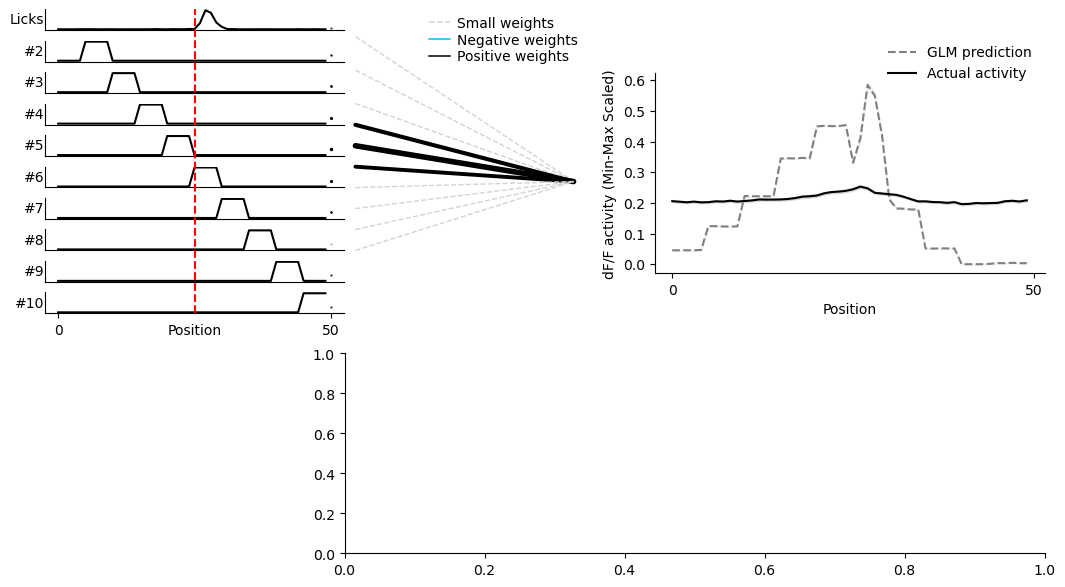

In [2]:
from GLM_regression import *
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams.update({'font.size': 10,
                     'axes.spines.right': False,
                     'axes.spines.top': False,
                     'legend.frameon': False})


# filepath = "SSTindivsomata_GLM.mat"
filepath = "NDNFindivsomata_GLM.mat"

reorganized_data, variable_list = load_data(filepath)
print(f"variable_list: {variable_list}")

def plot_example_neuron_variables(avg_variables, keep_vars_list, ax, weights=None):
    fig = ax.get_figure()

    # Define height ratios for each variable subplot
    height_ratios = np.ones(len(keep_vars_list))
    height_ratios[-10:] = 0.5  # Adjust the height for the last 10 variables (spatial bins)

    # Set up the grid for subplots
    axes = gs.GridSpecFromSubplotSpec(nrows=len(keep_vars_list), ncols=1, subplot_spec=ax, hspace=0.5, height_ratios=height_ratios)

    # Iterate through the variables and plot each one
    for i in range(len(keep_vars_list)):
        sub_ax = fig.add_subplot(axes[i])
        sub_ax.plot(avg_variables[:, i], color='k')  # Ensure correct indexing to plot the right variable

        # Set labels and ticks
        sub_ax.set_ylabel(keep_vars_list[i], rotation=0, ha='right', va='center', labelpad=0)
        sub_ax.set_xticks([])
        sub_ax.set_yticks([])

        # Plot weights as scatter points if provided
        if weights is not None:
            sub_ax.scatter([50], [0.3], c='k', s=abs(weights[i]) * 20)

    # Set x-axis labels for the bottom plot
    sub_ax.set_xlabel('Position', labelpad=-10)
    sub_ax.set_xticks([0, 50])

    # Draw vertical line across all plots (for visual separation)
    overlay_ax = fig.add_subplot(axes[:])
    overlay_ax.vlines(24.5, 0, 1, linestyles='--', color='r')
    overlay_ax.set_xlim([0, 49])
    overlay_ax.set_ylim([0, 1])
    overlay_ax.axis('off')
    overlay_ax.patch.set_alpha(0)


def plot_example_neuron_vars_removed(reorganized_data, variable_list, neuron='best', animal='best', vars_to_remove=[], model_name=None):

    GLM_params = {}
    
    if animal == 'best' or neuron == 'best':
        best_R2 = -np.inf
        best_animal = None
        best_neuron = None
        for animal_key in reorganized_data:
            GLM_params[animal_key] = {}
            for i, neuron_data in enumerate(reorganized_data[animal_key]):
                # Prepare data and train GLM
                neuron_data = reorganized_data[animal_key][i][:, :, 1:]
                neuron_data = neuron_data[:, :, ~np.isnan(neuron_data).any(axis=(0, 1))]

                def remove_variables(neuron_data, variable_list, vars_to_remove):
                    # Exclude the first column, which is the neuron activity
                    all_data_excluding_activity_var = neuron_data[:, 1:, :]  # Shape: (num_time_points, num_variables - 1, num_trials)

                    # Ensure vars_to_remove is a list, even if it's an integer
                    if isinstance(vars_to_remove, int):
                        vars_to_remove = [vars_to_remove]

                    if vars_to_remove is not None:
                        # Get the indices of the variables to remove based on their names
                        var_indices_to_remove = [variable_list.index(var) for var in vars_to_remove]
                        # Create an array of indices to keep, excluding the ones we want to remove
                        vars_to_exclude = np.delete(np.arange(all_data_excluding_activity_var.shape[1]), var_indices_to_remove)
                        updated_variable_list = [var for idx, var in enumerate(variable_list[1:]) if idx in vars_to_exclude]
                    else:
                        # If no variables are to be removed, just keep all the variables
                        vars_to_exclude = np.arange(all_data_excluding_activity_var.shape[1])
                        updated_variable_list = variable_list[1:]

                    # Filter the neuron_data to exclude the selected variables
                    neuron_data_filtered = all_data_excluding_activity_var[:, vars_to_exclude, :]

                    return neuron_data_filtered, updated_variable_list

                # Handle case if vars_to_remove is None or passed as an integer
                neuron_data_filtered, updated_variable_list = remove_variables(neuron_data, variable_list, vars_to_remove)

                # Apply min-max normalization to all variables, including neuron activity
                min_val = np.min(neuron_data, axis=(0, 2), keepdims=True)
                max_val = np.max(neuron_data, axis=(0, 2), keepdims=True)
                neuron_data = (neuron_data - min_val) / (max_val - min_val)
                
                flattened_data_filtered = []
                for j in range(neuron_data_filtered.shape[1]):
                    flattened_data_filtered.append(neuron_data_filtered[:, j].flatten())
                
                flattened_data_filtered = np.stack(flattened_data_filtered, axis=1)
                
                # Combine min-max normalized neuron activity with other min-max normalized features
                flattened_data_filtered = np.column_stack((neuron_data[:, 0, :].flatten(), flattened_data_filtered))
                
                # Check for NaNs and remove rows with NaNs
                if np.isnan(flattened_data_filtered).any():
                    print("nans in flattened_data_filtered")
                    continue

                # Ensure that the design matrix has at least one feature
                if flattened_data_filtered.shape[1] <= 1:
                    print("No features available after preprocessing")
                    continue
                
                # Flatten neuron_activity to match the shape of predicted_activity
                neuron_activity_flattened = neuron_data[:, 0, :].flatten()
                
                # Train GLM using filtered data
                design_matrix_X = flattened_data_filtered[:, 1:]  # Use filtered variables (skip the first column)
                neuron_activity_flattened = flattened_data_filtered[:, 0]  # Neuron activity as the dependent variable
                model = RidgeCV(alphas=[0.1, 1, 10, 100, 1000, 5000], cv=None)
                model.fit(design_matrix_X, neuron_activity_flattened)
                
                # Predict activity
                predicted_activity = model.predict(design_matrix_X)
                
                # Normalize the predicted activity for fair comparison
                predicted_activity = (predicted_activity - np.min(predicted_activity)) / (np.max(predicted_activity) - np.min(predicted_activity))
                
                # Calculate R² and Pearson correlation
                R2 = model.score(design_matrix_X, neuron_activity_flattened)
                pearson_R = np.corrcoef(predicted_activity, neuron_activity_flattened)[0, 1]
                
                GLM_params[animal_key][i] = {
                    'weights': model.coef_,
                    'intercept': model.intercept_,
                    'R2': R2,  # Store the R² value
                    'R2_trialavg': pearson_R ** 2,
                    'model': model
                }
                
                if R2 > best_R2:
                    best_R2 = R2
                    best_animal = animal_key
                    best_neuron = i

        animal = best_animal
        neuron = best_neuron
                    
        weights = GLM_params[animal][neuron]['weights']
        print(f" shape neuron_data_filtered {neuron_data_filtered.shape}")
        print(f"weights shape: {weights.shape}")   

        fig = plt.figure(figsize=(10,8))
        axes = gs.GridSpec(nrows=1, ncols=1, left=0, right=0.3, bottom=0.5)
        ax = fig.add_subplot(axes[0])
        ax.axis('off')

        # Calculate the average of the selected subset variables
        avg_variables = np.mean(neuron_data_filtered, axis=2)

        # Use updated_variable_list for plotting
        plot_example_neuron_variables(avg_variables, updated_variable_list, ax=ax, weights=weights)

    axes = gs.GridSpec(nrows=1, ncols=1, left=0.3, right=0.54, bottom=0.5)
    ax = fig.add_subplot(axes[0])
    ax.axis('off')
    y1 = np.linspace(-0.54, -1.86, 3).tolist()
    y2 = np.linspace(-2.28, -6, 10).tolist()
    y = y1 + y2
    w_max = np.max(np.abs(weights))
    for i,w in enumerate(weights):
        if abs(w)<0.05:
            line, = ax.plot([0,1], [y[i],-3.4], color='lightgray', linestyle='--', linewidth=1)
        elif w < 0:
            line, = ax.plot([0,1], [y[i],-3.4], color='deepskyblue', linewidth=abs(w/w_max)*4)
        else:
            line, = ax.plot([0,1], [y[i],-3.4], color='black', linewidth=abs(w/w_max)*4)
        line.set_solid_capstyle('round')
    ax.set_ylim([-6,0])
    ax.plot([0,0], [0,0], color='lightgray', linewidth=1.1, linestyle='--', label='Small weights')
    ax.plot([0,0], [0,0], color='deepskyblue', linewidth=1.1, label='Negative weights')
    ax.plot([0,0], [0,0], color='black', linewidth=1.1, label='Positive weights')
    ax.legend(fontsize=10, loc='upper right', frameon=False, handlelength=1.5, handletextpad=0.5, labelspacing=0.2, borderpad=0)

    glm_model = GLM_params[animal][neuron]['model']
    flattened_input_variables = flattened_data_filtered[:,1:]
    predicted_activity = glm_model.predict(flattened_input_variables)

    # Apply min-max normalization to the predicted activity again for consistency
    predicted_activity = (predicted_activity - np.min(predicted_activity)) / (np.max(predicted_activity) - np.min(predicted_activity))
    
    # Ensure the neuron activity is normalized too
    neuron_activity = neuron_data[:, 0, :]
    
    # Reshape activities for averaging
    predicted_activity = predicted_activity.reshape(neuron_activity.shape)
    avg_predicted_activity = np.mean(predicted_activity, axis=1)
    std_predicted_activity = np.std(predicted_activity, axis=1)
    sem_predicted_activity = std_predicted_activity / np.sqrt(predicted_activity.shape[1])
    
    avg_neuron_activity = np.mean(neuron_activity, axis=1)
    std_neuron_activity = np.std(neuron_activity, axis=1)
    sem_neuron_activity = std_neuron_activity / np.sqrt(neuron_activity.shape[1])

    pearson_R = np.corrcoef(avg_predicted_activity, avg_neuron_activity)[0,1]
    print("pearson R2 average:", pearson_R**2)

    axes = gs.GridSpec(nrows=1, ncols=1, left=0.61, right=1, top=0.8, bottom=0.55)
    ax = fig.add_subplot(axes[0])
    ax.plot(avg_predicted_activity, label='GLM prediction', c='gray', linestyle='--')
    ax.plot(avg_neuron_activity, label='Actual activity', c='k')
    ax.fill_between(np.arange(avg_neuron_activity.shape[0]), avg_neuron_activity-sem_neuron_activity, avg_neuron_activity+sem_neuron_activity, alpha=0.1, color='k')
    ax.fill_between(np.arange(avg_predicted_activity.shape[0]), avg_predicted_activity-sem_predicted_activity, avg_predicted_activity+sem_predicted_activity, alpha=0.1, color='gray')
    ax.set_xlabel("Position")
    ax.set_xticks([0,50])
    ax.set_ylabel("dF/F activity (Min-Max Scaled)")
    ax.legend(loc='upper right', bbox_to_anchor=(1, 1.2))

    axes = gs.GridSpec(nrows=1, ncols=1, top=0.45, bottom=0.2, left=0.3, right=1)
    ax = fig.add_subplot(axes[0])
    
    def plot_GLM_summary_data(GLM_params, keep_vars_list, vars_to_remove, ax):
        jitter = 0.1  # Jitter for better visualization

        animal_averages = []

        for animal_key in GLM_params:
            neuron_weights = []
            for neuron_nr in GLM_params[animal_key]:
                weights = GLM_params[animal_key][neuron_nr]['weights']
                variable_indices = np.arange(len(weights))  # Length of weights, not variable_list[vars_to_remove:]

                # Add jitter to x-axis for better visualization
                jittered_x = variable_indices + np.random.uniform(-jitter, jitter, len(weights))
                ax.scatter(jittered_x, weights, color='grey', alpha=0.2, s=10)

                neuron_weights.append(weights)

            # Calculate the mean weights for each animal
            neuron_weights = np.array(neuron_weights)
            mean_weights = np.mean(neuron_weights, axis=0)
            animal_averages.append(mean_weights)
            print(f" len(keep_vars_list): {len(keep_vars_list)} len(mean_weights) {len(mean_weights)}")
            ax.scatter(range(len(keep_vars_list)), mean_weights, color='black', label=f'Animal {animal_key}', s=20)
        
        
        # Calculate and plot the global mean (mean of all animals' means)
        animal_averages = np.array(animal_averages)
        global_mean = np.mean(animal_averages, axis=0)
        global_std = np.std(animal_averages, axis=0)
        ax.errorbar(np.arange(len(keep_vars_list)) - 0.15, global_mean, yerr=global_std, fmt='o', color='red', ecolor='red', capsize=5, label='Average of all animals', markersize=7)

        # Configure x-axis labels and other plot settings
        
        ax.set_xticks(np.arange(len(keep_vars_list)))
        ax.set_xticklabels(keep_vars_list, rotation=45, ha='right')
        ax.set_ylabel('Weights')
        ax.hlines(0, -0.5, len(weights) - 0.5, linestyles='--', color='black', alpha=0.5)
        ax.set_xlim([-0.5, len(weights) - 0.5])

    plot_GLM_summary_data(GLM_params, keep_vars_list, vars_to_remove, ax)

    axes = gs.GridSpec(nrows=1, ncols=1, top=0.45, bottom=0.2, left=0., right=0.2)
    ax = fig.add_subplot(axes[0])
    plot_R2_distribution(GLM_params, ax=ax)

    if model_name is not None:
        fig.savefig(f"figures/GLM_regression_{model_name}_{animal}_{neuron}.png", bbox_inches='tight', dpi=300)
                    

plot_example_neuron_vars_removed(reorganized_data, variable_list, neuron='best', animal='best', vars_to_remove=['Licks', 'R_loc', 'Speed'], model_name=None)
